In [2]:
import pandas as pd
import numpy as np
#!pip install dask[dataframe]
#!pip install pandas --upgrade
# We have to do this as dask is bad at guessing the types of objects for some reason
# Also, if you are having trouble with running the dataframe and continuously get 
# Fatal Python error: GC object already tracked, try to update pandas
df = pd.read_csv('crimes.csv')

In [3]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
#!pip install descartes
#!pip install fiona
#!pip install shapely
from descartes import PolygonPatch
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape

# This community area shapefile can be found:
# https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6
# After downloading and unzipping, make sure to rename every file as community_areas.*
mp = [] 
comm_areas = []

with fiona.open('community_areas.shp') as fil:
    mp = MultiPolygon([shape(pol['geometry']) for pol in fil])
    comm_areas = [int(area['properties']['area_numbe']) for area in fil]

In [48]:
%matplotlib inline
# Plots the community areas on a graph and colors them according to data. Data should be a dictionary of the form
# {comm_area: value, ...} where value is an integer value
def plot_against_comm_area(data, title = None):
    # We can now do GIS-ish operations on each borough polygon!
    # we could randomize this by dumping the polygons into a list and shuffling it
    # or we could define a random colour using fc=np.random.rand(3,)
    # available colour maps are here: http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
    cm = plt.get_cmap('YlOrRd')
    num_colours = len(mp)

    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111)
    minx, miny, maxx, maxy = mp.bounds
    w, h = maxx - minx, maxy - miny
    ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
    ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
    ax.set_aspect(1)

    # Convert data to be [0, 1]
    old_max = max(data.values())
    old_min = min(data.values())
    old_range = (old_max - old_min)  
    new_max = 1.0
    new_min = 0.0
    new_range = (new_max - new_min)
    data = {key: (((data[key] - old_min) * new_range) / old_range) + new_min for key in data.keys()}
    
    # Plot the data
    patches = []
    for idx, p in enumerate(mp):
        colour = cm(data[comm_areas[idx]])
        patches.append(PolygonPatch(p, fc=colour, ec='#555555', alpha=1., zorder=1))
    ax.add_collection(PatchCollection(patches, match_original=True))
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

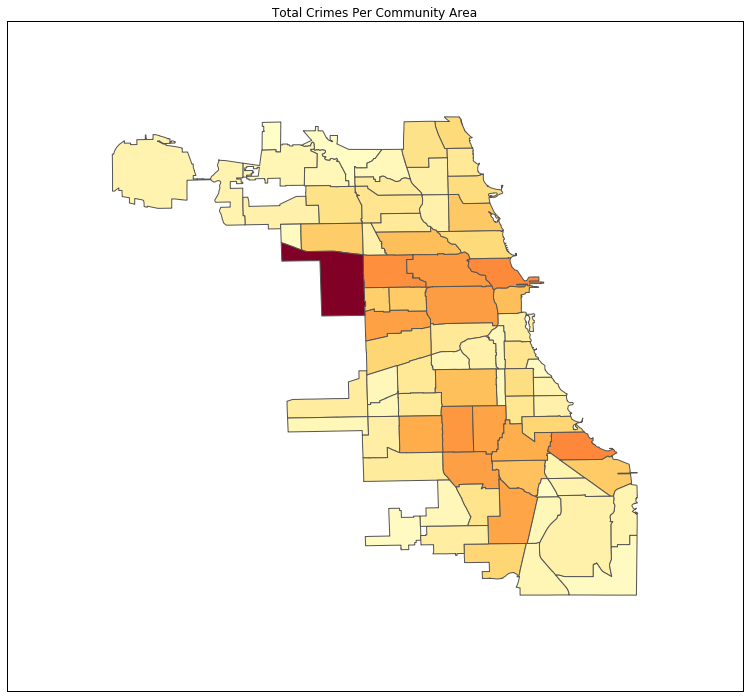

In [33]:
# Plot total crimes per community area
total_community_area_crimes = df['Community Area'].value_counts().astype(np.float64)
total_community_area_crimes = {key: total_community_area_crimes[key] for key in total_community_area_crimes.keys()}
# Plot
plot_against_comm_area(total_community_area_crimes, "Total Crimes Per Community Area")

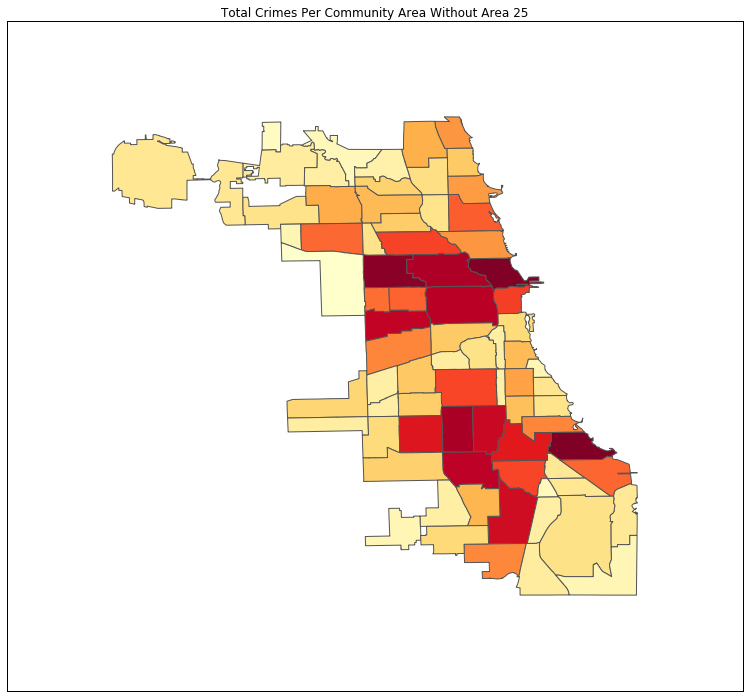

In [63]:
# Plot without the one large outlier
total_community_area_crimes = df['Community Area'].value_counts().astype(np.float64)
total_community_area_crimes = {key: total_community_area_crimes[key] for key in total_community_area_crimes.keys()}
total_community_area_crimes[25] = 0
# Plot
plot_against_comm_area(total_community_area_crimes, "Total Crimes Per Community Area Without Area 25")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


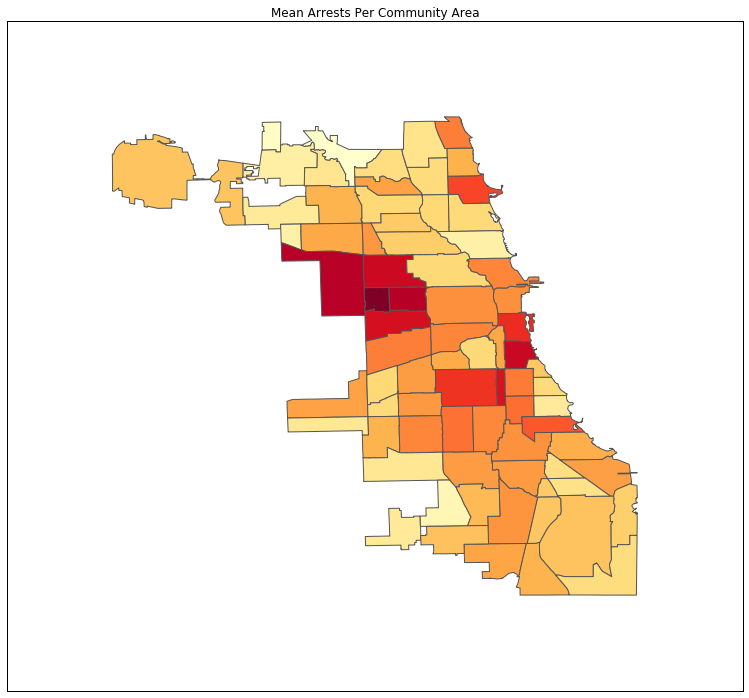

In [59]:
arrests = df[['Arrest', 'Community Area']]
arrests['Arrest'] = arrests['Arrest'].astype(np.float64)
mean_arr_per_area = arrests.groupby('Community Area').mean()
plot_against_comm_area(mean_arr_per_area.to_dict()['Arrest'], "Mean Arrests Per Community Area")